In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby

In [2]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [3]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

print(len(words_list))

np.random.shuffle(words_list)

96456


In [4]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [5]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


[',', 'of', 'existence', 'point', 'used', 'so', 'the', ',', 'and', 'have']

In [7]:
for text in train_labels_cleaned:
  if len(text) >= max_len:
        print(text)

plate-and-corrugation
middle-income-bracket


In [8]:
vocab = []
for vocabs in characters:
  vocab.append(vocabs)
vocab = sorted(vocab)
print(vocab ,end=" ")

['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

print(char_to_num.get_vocabulary())

# Mapping integers back to original characters.
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

['[UNK]', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [2]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [12]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [13]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

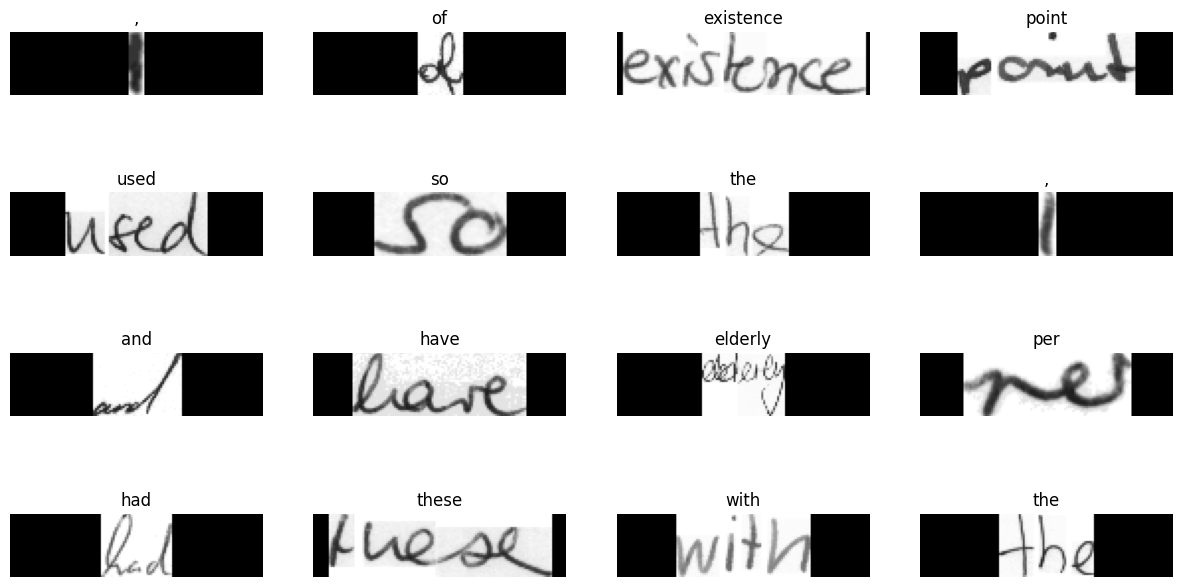

In [14]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.utils import get_custom_objects



# Clear all previously registered custom objects
# @get_custom_objects().clear()

@register_keras_serializable(package="Custom", name="CTCLayer")
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

    def get_config(self):
        config = super().get_config()
        config.update({"name": self.name})
        return config

    @classmethod
    def from_config(cls, config): # Define from_config to deserialize layer configuration
        return cls(**config)

In [16]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)

    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = keras.layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)
    x = keras.layers.Dropout(0.2)(x)
    #first max pooling layer
    x = keras.layers.Conv2D(
        1024,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv8",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    #first max pooling layer

    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv7",
    )(x)
    # x=keras.layers.MaxPooling2D((2, 2), name="pool3")(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(1024, return_sequences=True, dropout=0.3)
    )(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

    # Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv4 (Conv2D)            │ (None, 128, 32, 128)   │         36,992 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 128)    │              0 │ Conv4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv6 (Conv2D)            │ (None, 64, 16, 256)    │        295,168 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 16, 256)    │              0 │ Conv6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv8 (Conv2D)            │ (None, 64, 16, 1024)   │      2,360,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 1024)    │              0 │ Conv8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv7 (Conv2D)            │ (None, 32, 8, 64)      │        589,888 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ Conv7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32, 2048)       │      8,921,088 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 32, 1024)       │     10,489,856 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 32, 128)        │        557,568 │ bidirectional_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                      

 Total params: 23,294,481 (88.86 MB)

 Trainable params: 23,294,481 (88.86 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [18]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [19]:
epochs = 1 # To get good results this should be at least 50.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("handwriting.keras", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)

model = build_model()
prediction_model = keras.models.Model(
    inputs=model.inputs[0],  # Use model.inputs[0] to get the "image" input
    outputs=model.get_layer(name="dense2").output
    #inputs= model.get_layer(name="image").input, outputs= model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb,early_stopping_cb,edit_distance_callback],
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━

len is :  2
batch img shape:  (128, 32, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


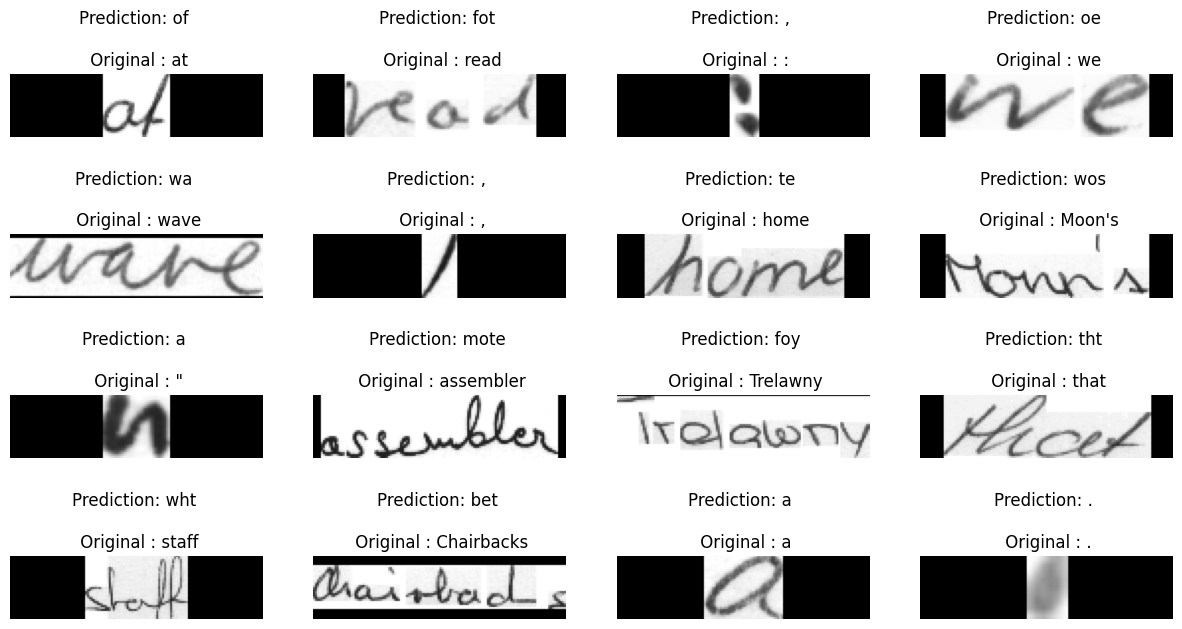

In [20]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        # print(img.shape)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [21]:
total_count = 0
correct_count = 0

for batch in test_ds.take(75):
    batch_images,batch_labels = batch["image"],batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(64):
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")


        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        total_count = total_count+1
        if(label == pred_texts[i]):
          correct_count = correct_count+1


print("Total count : ",total_count)

print("Correct count : ",correct_count)

percentage = (correct_count/total_count)*100
print(f"Percentage : {percentage}% .")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━

In [4]:
# model.save("handwriting_with_custom.h5")
loaded_model = keras.models.load_model("C:/Users/shivs/Desktop/AGILE ICO/Live_Detection/handwriting_with_custom.h5", custom_objects={'CTCLayer': CTCLayer})
loaded_model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv4 (Conv2D)      │ (None, 128, 32,   │     36,992 │ Conv1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 16,    │          0 │ Conv4[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv6 (Conv2D)      │ (None, 64, 16,    │    295,168 │ pool1[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 16,    │          0 │ Conv6[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv8 (Conv2D)      │ (None, 64, 16,    │  2,360,320 │ dropout_2[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 32, 8,     │          0 │ Conv8[0][0]       │
│ (MaxPooling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv7 (Conv2D)      │ (None, 32, 8, 64) │    589,888 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ Conv7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 32, 2048)  │  8,921,088 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 32, 1024)  │ 10,489,856 │ bidirectional_3[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 32, 128)   │    557,568 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 81)    │     10,449 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 81)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,294,483 (88.86 MB)

 Trainable params: 23,294,481 (88.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [4]:
logits_layer = loaded_model.get_layer("dense2")  
print(logits_layer.output)


<KerasTensor shape=(None, 32, 81), dtype=float32, sparse=False, name=keras_tensor_29>


In [5]:
from tensorflow import keras

# Verify and retrieve layers by their names
input_layer = loaded_model.input[0]  # Ensure 'image' is the correct name
output_layer = loaded_model.get_layer(name="dense2").output  # Ensure 'dense2' is the correct name

# Create the prediction model
prediction_model = keras.Model(inputs=input_layer, outputs=output_layer)
prediction_model.summary()
# predictions = prediction_model.predict(your_input_data)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 32, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 32, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 128, 32, 128)   │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 64, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv8 (Conv2D)                  │ (None, 64, 16, 1024)   │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 8, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv7 (Conv2D)                  │ (None, 32, 8, 64)      │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32, 2048)       │     8,921,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32, 1024)       │    10,489,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32, 128)        │       557,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32, 81)         │        10,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,294,481 (88.86 MB)

 Trainable params: 23,294,481 (88.86 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# FOR WEB CAMERA DETECTION
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the model
loaded_model = keras.models.load_model(
    "C:/Users/shivs/Desktop/AGILE ICO/Live_Detection/handwriting_with_custom.h5",
    custom_objects={'CTCLayer': CTCLayer}
)

# Extract the input and output layers for inference
input_image = loaded_model.input[0]  # The image input
output_logits = loaded_model.get_layer("dense2").output  # Replace "dense2" with your logits layer name

# Create an inference model
prediction_model = keras.Model(inputs=input_image, outputs=output_logits)

def preprocess_frame(frame, target_size=(32, 128)):
    """
    Preprocess the frame for model prediction.
    Resizes the frame and normalizes pixel values.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize to model's input shape
    resized = cv2.resize(gray, target_size)
    # Normalize pixel values (assuming your model expects values in range [0, 1])
    normalized = resized / 255.0
    # Expand dimensions to match model input shape
    preprocessed = np.expand_dims(normalized, axis=0)  # Add batch dimension
    preprocessed = np.expand_dims(preprocessed, axis=-1)  # Add channel dimension
    return preprocessed

# Access the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Unable to access the webcam.")
    exit()

print("Press 'q' to exit.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read from the webcam.")
        break

    # Display the original frame
    cv2.imshow("Webcam - Original", frame)

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Get logits from the inference model
    logits_output = prediction_model.predict(preprocessed_frame, verbose=0)

    # Decode the logits using CTC decoding
    input_length = np.ones(logits_output.shape[0]) * logits_output.shape[1]  # Lengths of time steps
    decoded_predictions = tf.keras.backend.ctc_decode(
        logits_output, 
        input_length=input_length, 
        greedy=True
    )[0][0]

    # Debug: Check the type of `decoded_predictions`
    # print("Type of decoded_predictions:", type(decoded_predictions))

    # Convert to NumPy if already dense
    if isinstance(decoded_predictions, tf.Tensor):
        decoded_predictions = decoded_predictions.numpy()

    # Extract and decode the prediction
    predicted_label = "".join([chr(c) for c in decoded_predictions[0] if c > 0])  # Adjust based on vocabulary
    print("Predicted Label:", predicted_label)

    # Display the prediction on the frame
    label_text = f"Prediction: {predicted_label}"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame with prediction
    cv2.imshow("Webcam - Prediction", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to exit.
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted Label: 
Predicted La

In [6]:
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [7]:
max_len = 21
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

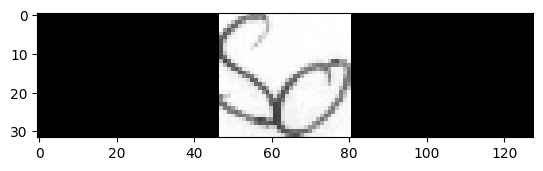

(32, 128)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
# FOR CUSTOM INPUTS
img_path = "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGSo.png"
image2 = preprocess_image(img_path)
# label = vectorize_label(label)
img2 = tf.image.flip_left_right(image2)
img2 = tf.transpose(img2, perm=[1, 0, 2])
img2 = (img2 * 255.0).numpy().clip(0, 255).astype(np.uint8)
img2 = img2[:, :, 0]
plt.imshow(img2,cmap="gray")
plt.show()
img_list = [img2]
print(img2.shape)


In [9]:
from tensorflow.data import AUTOTUNE

batch_size = 7
def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices(img_paths_3).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [10]:
img_paths_3 = ["C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGSo.png",
               "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGLeads.png",
               "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGMission.png",
            #    "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGgoodmornig.jpg",
               "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGTo.png",
               "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGVery.png",
               "C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGRetirement.png"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

In [11]:
for batch in custom_ds.take(1):
    print(f"Batch shape: {[element.shape for element in batch]}")


Batch shape: [TensorShape([128, 32, 1]), TensorShape([128, 32, 1]), TensorShape([128, 32, 1]), TensorShape([128, 32, 1]), TensorShape([128, 32, 1]), TensorShape([128, 32, 1])]


In [12]:
characters=['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

print(char_to_num.get_vocabulary())

# Mapping integers back to original characters.
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

['[UNK]', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Batch: tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0

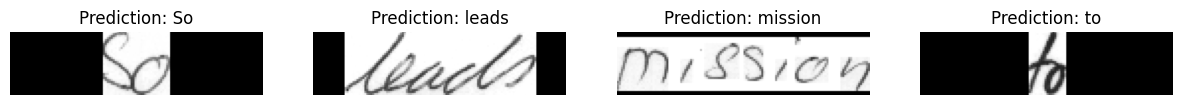

In [13]:
for batch in custom_ds.take(1):
    print("Batch:", batch)  # Check the content of the batch
    print("Length of batch:", len(batch))
    
    # Debugging batch shapes
    try:
        print("Batch 0 shape:", batch[0].shape)
        print("Batch 1 shape:", batch[1].shape)
    except AttributeError as e:
        print(f"Error accessing batch shapes: {e}")

    _, ax = plt.subplots(1, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch)
    print("Predictions:", preds)

    pred_texts = decode_batch_predictions(preds)
    print("Decoded Predictions:", pred_texts)

    for i in range(4):
        try:
            img = batch[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i].imshow(img, cmap="gray")
            ax[i].set_title(title)
            ax[i].axis("off")
        except IndexError as e:
            print(f"Error processing image {i}: {e}")

plt.show()


In [31]:
val_loss_list = history.history["val_loss"]
print(val_loss_list)

loss_list = history.history["loss"]
print(loss_list)
len(val_loss_list),len(loss_list)
plot_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21,22,23,24,25,26,27,28,29,30,31]
plt.plot(plot_list, loss_list,label="loss")
plt.plot(plot_list, val_loss_list,label="var_loss")
plt.legend()

NameError: name 'history' is not defined

In [17]:
print(loaded_model.input)


[<KerasTensor shape=(None, 128, 32, 1), dtype=float32, sparse=False, name=image>, <KerasTensor shape=(None, None), dtype=float32, sparse=False, name=label>]


In [1]:
import cv2

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Unable to access the webcam.")
else:
    print("Webcam accessed successfully.")
cap.release()


Webcam accessed successfully.


In [2]:
import cv2

# Initialize the webcam (default camera index is 0)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Unable to access the webcam.")
    exit()

print("Press 'q' to exit.")

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Unable to read from the webcam.")
        break

    # Display the frame
    cv2.imshow("Webcam", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


Press 'q' to exit.


In [2]:
import numpy as np
import matplotlib
import tensorflow as tf

print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.26.4
Matplotlib version: 3.8.0
TensorFlow version: 2.17.1


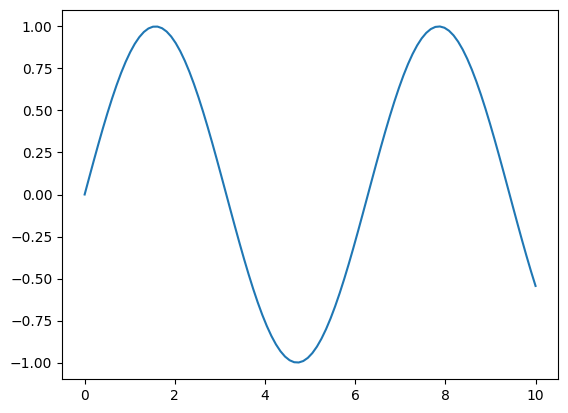

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y)
plt.show()


In [10]:
pwd

'c:\\Users\\shivs\\Desktop\\AGILE ICO\\AiMl-Models'

In [12]:
os.path.isfile('C:/Users/shivs/Desktop/AGILE ICO/Live_Detection/handwriting_with_custom.h5')

True

In [93]:
import os
os.path.isfile('C:/Users/shivs/Desktop/AGILE ICO/AiMl-Models/Custom_Images/IMGgoodmornig.jpg')

True

In [13]:
pwd


'/mnt/c/Users/shivs/Desktop/AGILE ICO/AiMl-Models'

In [14]:
cd AiMl-Models

[Errno 2] No such file or directory: 'AiMl-Models'
/mnt/c/Users/shivs/Desktop/AGILE ICO/AiMl-Models


/root/miniconda3/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [15]:
ls


 Handwritting_Detection_Model_2.ipynb*
 Handwritting_detection_model_82.ipynb*
 TEST_Model.ipynb*
'handwriting (1).keras'*
 handwriting.keras*
 handwritting-detection-model2_HA.ipynb*
 handwritting_detection_model2_Test.ipynb*
 my_model.h5*


In [16]:
cd ..


/mnt/c/Users/shivs/Desktop/AGILE ICO


/root/miniconda3/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [17]:
ls

AiMl-Models/  Live_Detection/  Refference/  pos-detection-tensorflow-js/


In [23]:
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv4 (Conv2D)            │ (None, 128, 32, 128)   │         36,992 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 128)    │              0 │ Conv4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv6 (Conv2D)            │ (None, 64, 16, 256)    │        295,168 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 16, 256)    │              0 │ Conv6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv8 (Conv2D)            │ (None, 64, 16, 1024)   │      2,360,320 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 1024)    │              0 │ Conv8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv7 (Conv2D)            │ (None, 32, 8, 64)      │        589,888 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ Conv7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 32, 2048)       │      8,921,088 │ dropout_3[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 32, 1024)       │     10,489,856 │ bidirectional_3[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 32, 128)        │        557,568 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                      

 Total params: 69,883,445 (266.58 MB)

 Trainable params: 23,294,481 (88.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,588,964 (177.72 MB)